In [9]:
%matplotlib inline
import zipline
from zipline.api import order_target_percent, symbol, schedule_function, date_rules, time_rules, set_commission, set_slippage
from zipline.finance.commission import PerDollar
from zipline.finance.slippage import VolumeShareSlippage, FixedSlippage
from pandas import Timestamp
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

from zipline.pipeline.factors import SimpleMovingAverage, ExponentialWeightedMovingAverage

"""
Prior to running this, create a new bundle in extension.py:

from zipline_norgatedata import register_norgatedata_equities_bundle

register_norgatedata_equities_bundle(
    bundlename = 'norgatedata-selected-etfs2',
    symbol_list = ['SPY','TLT','IEF','GLD','DBC'],
    start_session = '1990-01-01', # This is the USO first trading date
)
    
and also run:

zipline ingest -b norgatedata-selected-etfs2

"""

def analyze(context, perf):
    
    perf['max'] = perf.portfolio_value.cummax()
    perf['dd'] = (perf.portfolio_value / perf['max']) - 1
    maxdd = perf['dd'].min()
    sharpe = perf.sharpe.iloc[-1]
    ann_ret = (np.power((perf.portfolio_value.iloc[-1] / perf.portfolio_value.iloc[0]),(252 / len(perf)))) - 1
    
    print("Annualized Return: {:.2%} Max Drawdown: {:.2%} Sharpe: {:.4}".format(ann_ret, maxdd, sharpe))
    
    # add functions to export results for R markdown reporting

    return

#        'SPY' : 1.0

def initialize(context):
    enable_commission=parameters['enable_commission']
    commission_pct=parameters['commission_pct']
    enable_slippage=parameters['enable_slippage']
    slippage_volume_limit=parameters['slippage_volume_limit']
    slippage_impact=parameters['slippage_impact']
    
    # Securities and target weights
    context.allocation = {
        'SPY' : 0.95,
    }
    
    # Set commission and slippage.
    if enable_commission:
        comm_model = PerDollar(cost=commission_pct)
    else:
        comm_model = PerDollar(cost=0.0)
    set_commission(comm_model)

    if enable_slippage:
        slippage_model=VolumeShareSlippage(volume_limit=slippage_volume_limit,
            price_impact=slippage_impact)
        set_slippage(slippage_model)
    else:
        slippage_model=FixedSlippage(spread=0.0)       
    
    # Schedule rebalance for once a month
    schedule_function(rebalance, date_rules.month_start(), time_rules.market_open())
    
def rebalance(context, data):
    # extract parameters
    enable_trend_filter=parameters['enable_trend_filter']
    trend_filter_window=parameters['trend_filter_window']
    trend_filter_symbol=parameters['trend_filter_symbol']
    
    # UPDATE TREND FILTER STATE
    # determine trend filter state
    if enable_trend_filter:
        # fetch historical total return index data for universe
        index_data_window = data.history(symbol(trend_filter_symbol),
            'close',trend_filter_window,'1d')
        # determine trend filter state
        trend_filter_state = index_data_window.iloc[-1] > index_data_window.mean()
        # if trend filter state is false, skip adding new positions
    else:
        trend_filter_state = True    
    
    # PROCESS EXITS
    
    # create open position list
    open_positions = list(context.portfolio.positions.keys())
    # iterate over open positions
    for instrument in context.portfolio.positions:
        # close position if no longer in index universe
        if (trend_filter_state == False):
            # place order to close position
            order_target_percent(instrument, 0.0)
            # remove position from open position list
            open_positions.remove(instrument)
    
    # move to next date
    if trend_filter_state == False:
        return        
    
    # iterate over instruments and rebalance to target weights
    for ticker, weight in context.allocation.items():
        instrument = symbol(ticker)
        # check if we can trade
        if data.can_trade(instrument):
            # Reset the weight
            order_target_percent(instrument, weight)
            
    return
            
def tail_ratio(returns):
    """Determines the ratio between the right (95%) and left tail (5%).
    For example, a ratio of 0.25 means that losses are four times
    as bad as profits.
    Parameters
    ----------
    returns : pd.Series
        Daily returns of the strategy, noncumulative.
         - See full explanation in tears.create_full_tear_sheet.
    Returns
    -------
    float
        tail ratio
    """

    return np.abs(np.percentile(returns, 95)) / np.abs(np.percentile(returns, 5))

def extractSymbol(ziplineTicker):
    return ziplineTicker.split('[')[1].split(']')[0]

def writePositions(outputDirectory,strategyName,perf):
    # define output file name
    outputFileName=strategyName+'_positions.csv'
    # open output file handle
    outputFileHandle=open(outputDirectory+outputFileName,'w')
    # set header flag
    headerFlag=True
    # iterate over position object
    for dateTime,positions in perf.positions.items():
        # if we have positions for datetime
        if len(positions)>0:
            df=pd.DataFrame(positions)
            df['datetime']=dateTime
            df['symbol']=df['sid'].apply(lambda x : extractSymbol(str(x)))
            df['strategyName']=strategyName
            
            if headerFlag:
                df.to_csv(outputFileHandle,header=True,index=False,
                    columns=['sid','symbol','datetime','amount','cost_basis',
                    'last_sale_price'])
                # set header flag
                headerFlag=False
            else:
                df.to_csv(outputFileHandle,header=False,index=False,
                    columns=['sid','symbol','datetime','amount','cost_basis',
                    'last_sale_price'])
    # close output file handle
    outputFileHandle.close()
    return outputFileName

def writeTransactions(outputDirectory,strategyName,perf):
    # define output file name
    outputFileName=strategyName+'_transactions.csv'    
    # open output file handle
    outputFileHandle=open(outputDirectory+outputFileName,'w')
    # set header flag
    headerFlag=True
    # iterate over transactions object
    for dateTime,transactions in perf.transactions.items():
        # if we have transactions for datetime
        if len(transactions)>0:
            df=pd.DataFrame(transactions)
            df['datetime']=dateTime
            df['symbol']=df['sid'].apply(lambda x : extractSymbol(str(x)))
            df['strategyName']=strategyName
            
            if headerFlag:
                df.to_csv(outputFileHandle,header=True,index=False,
                    columns=['sid','symbol','datetime','order_id','amount',
                    'price','commission','dt'])
                # set header flag
                headerFlag=False
            else:
                df.to_csv(outputFileHandle,header=False,index=False,
                    columns=['sid','symbol','datetime','order_id','amount',
                    'price','commission','dt'])
    # close output file handle
    outputFileHandle.close()
    return outputFileName

def writeOrders(outputDirectory,strategyName,perf):
    # define output file name
    outputFileName=strategyName+'_orders.csv'
    # open output file handle
    outputFileHandle=open(outputDirectory+outputFileName,'w')
    # set header flag
    headerFlag=True
    # iterate over orders object
    for dateTime,orders in perf.orders.items():
        # if we have transactions for datetime
        if len(orders)>0:
            df=pd.DataFrame(orders)
            df['datetime']=dateTime
            df['symbol']=df['sid'].apply(lambda x : extractSymbol(str(x)))
            df['strategyName']=strategyName
            
            if headerFlag:
                df.to_csv(outputFileHandle,header=True,index=False,
                    columns=['sid','symbol','datetime','id','amount','commission',
                    'created','dt','filled','limit','limit_reached','reason',
                    'status','stop','stop_reached'])
                # set header flag
                headerFlag=False
            else:
                df.to_csv(outputFileHandle,header=False,index=False,
                    columns=['sid','symbol','datetime','id','amount','commission',
                    'created','dt','filled','limit','limit_reached','reason',
                    'status','stop','stop_reached'])
    # close output file handle
    outputFileHandle.close()
    return outputFileName

def writeStrategyOutput(outputDirectory,strategyName,perf):
    performance=pd.concat([perf.period_open,perf.period_close,perf.trading_days,
        perf.capital_used,perf.starting_cash,perf.starting_exposure,perf.starting_value,
        perf.ending_cash,perf.ending_exposure,perf.ending_value,perf.long_exposure,
        perf.long_value,perf.longs_count,perf.short_exposure,perf.short_value,
        perf.shorts_count,perf.pnl,perf.portfolio_value,perf.returns,perf.gross_leverage,
        perf.net_leverage,perf.max_leverage,perf.dd,perf.max_drawdown,perf.sharpe,
        perf.sortino,perf.alpha,perf.beta,perf.excess_return,perf.algo_volatility,
        perf.algorithm_period_return,perf.benchmark_volatility,perf.benchmark_period_return],
        axis=1)
    
    # add strategy name
    performance['strategyName']=strategyName    
    # define output file name
    performanceFileName=strategyName+'_performance.csv'
    # write performance
    performance.to_csv(outputDirectory+performanceFileName)
    # write positions
    positionsFileName=writePositions(outputDirectory,strategyName,perf)
    # write positions
    transactionsFileName=writeTransactions(outputDirectory,strategyName,perf)
    # write positions
    ordersFileName=writeOrders(outputDirectory,strategyName,perf)    
    
    return performance,performanceFileName,positionsFileName,transactionsFileName,ordersFileName

outputDirectory = 'F:/Downloads/backtest/2005_2020/EQ95_TF/'            
strategyName='EQ95_TF'            

parameters=dict()
#parameters['start_date'] = Timestamp('2002-08-01',tz='UTC')
#parameters['start_date']=Timestamp('2000-01-01',tz='UTC')
parameters['start_date']=Timestamp('2005-01-01',tz='UTC')
parameters['end_date']=Timestamp('2020-02-14',tz='UTC')
parameters['bundle_name']='norgatedata-etf'
parameters['intial_portfolio']=100000
parameters['enable_commission']=True
parameters['commission_pct']=0.001
parameters['enable_slippage']=True
parameters['slippage_volume_limit']=0.1
parameters['slippage_impact']=0.05
parameters['enable_trend_filter']=True
parameters['trend_filter_window']=168
parameters['trend_filter_symbol']='$SPXTR'
parameters['strategyName']=strategyName

# Fire off backtest
result = zipline.run_algorithm(
    start=parameters['start_date'], # set start
    end=parameters['end_date'],  # set end
    initialize=initialize, # define startup function
    analyze=analyze, 
    capital_base=parameters['intial_portfolio'], # set initial capital
    data_frequency = 'daily',  # set data frequency
    bundle=parameters['bundle_name'] ) # select bundle

# write strategy output
performance,performanceFileName,positionsFileName,transactionsFileName,ordersFileName=writeStrategyOutput(outputDirectory,
    strategyName,result)

# extract parameter keys
keys=[str(key) for key in parameters.keys()]
# extract parameter values
values=[key for key in parameters.values()]
# create parameter data frame
parameterDf=pd.DataFrame(index=keys,data=values,columns=['parameterValue'])
# write parameters
parameterDf.to_csv(outputDirectory+strategyName+"_parameters.csv",index_label='parameterName')


[2020-02-15 20:31:44.747311] INFO: Loader: Downloading benchmark data for 'SPY' from 2004-12-31 00:00:00+00:00 to 2020-02-14 00:00:00+00:00
[2020-02-15 20:31:44.877826] WARNING: Loader: Refusing to download new treasury data because a download succeeded at 2020-02-15 20:30:53.197468+00:00.
[2020-02-15 20:31:53.585480] INFO: zipline.finance.metrics.tracker: Simulated 3806 trading days
first open: 2005-01-03 14:31:00+00:00
last close: 2020-02-14 21:00:00+00:00
Annualized Return: 8.59% Max Drawdown: -17.75% Sharpe: 0.8072


In [10]:
twr=(1+result.algorithm_period_return)
highTwr=twr.cummax()
dd=(twr/highTwr)-1
mpvd=dd.cummin()

In [11]:
days=parameters['end_date']-parameters['start_date']

In [12]:
(twr[-1]**(1.0/(days.days/365)))-1

0.08574391209531207

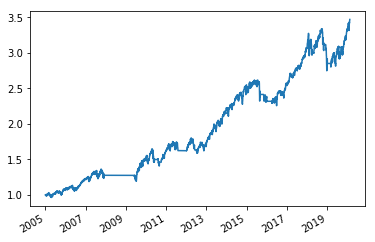

In [13]:
twr.plot()

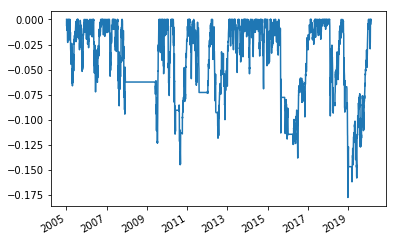

In [14]:
dd.plot()

In [15]:
result.positions[1]

[{'amount': 1066,
  'cost_basis': 87.97789000057102,
  'last_sale_price': 87.89,
  'sid': Equity(2602 [SPY])}]

In [16]:
result.sharpe[-1]

0.80718794838669